Constants

In [237]:
columns_to_drop=["Platform", "Other_Sales", "Critic_Count", "User_Count", "Rating", "Developer"]
needed_samples_lambda = lambda x: round((30./x)+1)
range_for_samples_lambda = lambda x: x*0.04 if x*0.04>0.01 else 0.01

def standardize(column):
    print("Max: {} Min: {}".format(column.max(), column.min()))
    stddev = column.std()
    mean = column.mean()
    return column.apply(lambda x: (x-mean)/stddev)

In [238]:
import pandas as pd
import numpy as np

data = pd.read_csv("../datasets/vg_sales_2016/vg_sales_2016.csv")
data = data.drop(columns=columns_to_drop)
data = data.replace({'tbd': np.NaN})
data["Critic_Score"] = pd.to_numeric(data["Critic_Score"])
data["User_Score"] = pd.to_numeric(data["User_Score"])

Remove entries without release date and with global sales less than 0.5

In [239]:
data = data.drop(data[((data["Year_of_Release"].isna()) & (data["Global_Sales"] < 0.5))].index)
print(data)

                                Name  Year_of_Release         Genre  \
0                         Wii Sports           2006.0        Sports   
1                  Super Mario Bros.           1985.0      Platform   
2                     Mario Kart Wii           2008.0        Racing   
3                  Wii Sports Resort           2009.0        Sports   
4           Pokemon Red/Pokemon Blue           1996.0  Role-Playing   
...                              ...              ...           ...   
16714  Samurai Warriors: Sanada Maru           2016.0        Action   
16715               LMA Manager 2007           2006.0        Sports   
16716        Haitaka no Psychedelica           2016.0     Adventure   
16717               Spirits & Spells           2003.0      Platform   
16718            Winning Post 8 2016           2016.0    Simulation   

          Publisher  NA_Sales  EU_Sales  JP_Sales  Global_Sales  Critic_Score  \
0          Nintendo     41.36     28.96      3.77         82.53   

Remove entries without Name

In [240]:
data = data.drop(data[data["Name"].isna()].index)
print(data)

                                Name  Year_of_Release         Genre  \
0                         Wii Sports           2006.0        Sports   
1                  Super Mario Bros.           1985.0      Platform   
2                     Mario Kart Wii           2008.0        Racing   
3                  Wii Sports Resort           2009.0        Sports   
4           Pokemon Red/Pokemon Blue           1996.0  Role-Playing   
...                              ...              ...           ...   
16714  Samurai Warriors: Sanada Maru           2016.0        Action   
16715               LMA Manager 2007           2006.0        Sports   
16716        Haitaka no Psychedelica           2016.0     Adventure   
16717               Spirits & Spells           2003.0      Platform   
16718            Winning Post 8 2016           2016.0    Simulation   

          Publisher  NA_Sales  EU_Sales  JP_Sales  Global_Sales  Critic_Score  \
0          Nintendo     41.36     28.96      3.77         82.53   

Entries without publisher will be filled manually

In [241]:
print(data[data["Publisher"].isna()])

                                                    Name  Year_of_Release  \
475                           wwe Smackdown vs. Raw 2006              NaN   
1301                                      Triple Play 99              NaN   
1667        Shrek / Shrek 2 2-in-1 Gameboy Advance Video           2007.0   
2212                                  Bentley's Hackpack           2005.0   
3148   Nicktoons Collection: Game Boy Advance Video V...           2004.0   
3159   SpongeBob SquarePants: Game Boy Advance Video ...           2004.0   
3755   SpongeBob SquarePants: Game Boy Advance Video ...           2004.0   
4508   The Fairly Odd Parents: Game Boy Advance Video...           2004.0   
4615   The Fairly Odd Parents: Game Boy Advance Video...           2004.0   
5633   Cartoon Network Collection: Game Boy Advance V...           2005.0   
6415            Sonic X: Game Boy Advance Video Volume 1           2004.0   
6532   Dora the Explorer: Game Boy Advance Video Volu...           2004.0   

There are no missing values in EU_Sales, JP_Sales, NA_Sales and Global_Sales

Generate missing Critic Score values.

In [242]:
print(data.count())

Name               16501
Year_of_Release    16448
Genre              16501
Publisher          16467
NA_Sales           16501
EU_Sales           16501
JP_Sales           16501
Global_Sales       16501
Critic_Score        8023
User_Score          7500
dtype: int64


In [243]:
data_for_global_sales_in_range = data[(data["Global_Sales"]<8) & (data["Global_Sales"]>=0.2)]
for index, values in data_for_global_sales_in_range[data_for_global_sales_in_range["Critic_Score"].isna()].iterrows():
    number_of_needed_samples = needed_samples_lambda(values["Global_Sales"])
    range_for_samples = range_for_samples_lambda(values["Global_Sales"])
    possible_samples = data.drop(data[data["Critic_Score"].isna()].index)
    possible_samples= possible_samples[(values["Global_Sales"] - range_for_samples <= possible_samples["Global_Sales"]) 
         & (values["Global_Sales"] + range_for_samples >= possible_samples["Global_Sales"])]
    if len(possible_samples.index) > number_of_needed_samples:
        randomized_critic_score = possible_samples.sample()["Critic_Score"]
        data.at[index, "Critic_Score"] = randomized_critic_score

Generate missing User Score values.

In [244]:
data_for_global_sales_in_range = data[(data["Global_Sales"]<8) & (data["Global_Sales"]>=0.2)]
for index, values in data_for_global_sales_in_range[data_for_global_sales_in_range["User_Score"].isna()].iterrows():
    number_of_needed_samples = needed_samples_lambda(values["Global_Sales"])
    range_for_samples = range_for_samples_lambda(values["Global_Sales"])
    possible_samples = data.drop(data[data["User_Score"].isna()].index)
    possible_samples= possible_samples[(values["Global_Sales"] - range_for_samples <= possible_samples["Global_Sales"]) 
         & (values["Global_Sales"] + range_for_samples >= possible_samples["Global_Sales"])]
    if len(possible_samples.index) > number_of_needed_samples:
        randomized_user_score = possible_samples.sample()["User_Score"]
        data.at[index, "User_Score"] = randomized_user_score

In [245]:
print(data.count())

Name               16501
Year_of_Release    16448
Genre              16501
Publisher          16467
NA_Sales           16501
EU_Sales           16501
JP_Sales           16501
Global_Sales       16501
Critic_Score       11110
User_Score         10609
dtype: int64


Remove games without Critic or User Score with global sales below 0.2m

In [246]:
data = data.drop(data[
    (data["Critic_Score"].isna() | data["User_Score"].isna()) &
    (data["Global_Sales"]<0.2)
].index)

Normalization & Standardization

In [247]:
data["Critic_Score"] = data["Critic_Score"] / 100.
data["User_Score"] = data["User_Score"] / 10.

data["Global_Sales"] = standardize(data["Global_Sales"])
data["EU_Sales"] = standardize(data["EU_Sales"])
data["JP_Sales"] = standardize(data["JP_Sales"])
data["NA_Sales"] = standardize(data["NA_Sales"])
print(data["Critic_Score"])

Max: 82.53 Min: 0.01
Max: 28.96 Min: 0.0
Max: 10.22 Min: 0.0
Max: 41.36 Min: 0.0
0        0.76
1         NaN
2        0.82
3        0.80
4         NaN
         ... 
16677    0.81
16696    0.80
16700    0.61
16706    0.60
16709    0.63
Name: Critic_Score, Length: 10353, dtype: float64


Critic Score to User Score

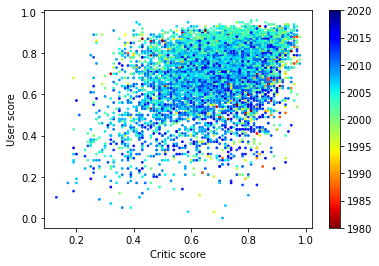

In [248]:
from scripts.scatter_plotter import ScatterPlotter
category_column = "Year_of_Release"
ScatterPlotter(data.Critic_Score, data.User_Score, data[category_column])\
    .with_labels('Critic score', 'User score')\
    .with_color_bar()\
    .plot()

Sales per region considering Critic Score

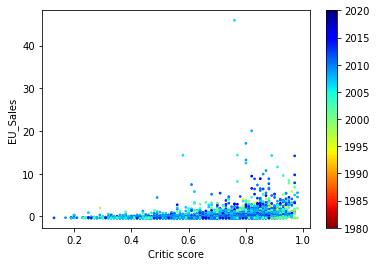

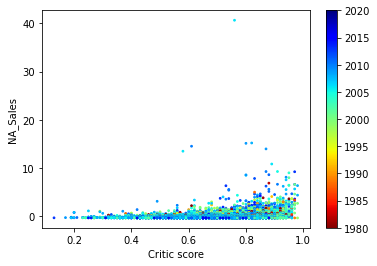

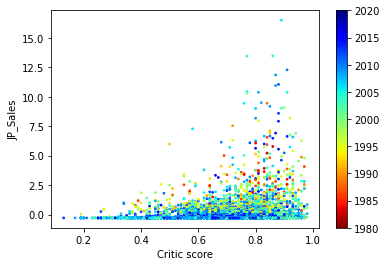

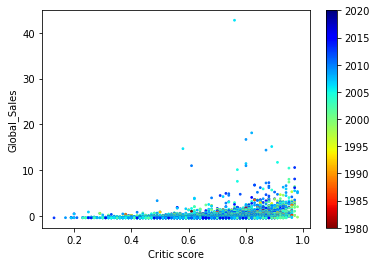

In [249]:
category_column = "Year_of_Release"
ScatterPlotter(data.Critic_Score, data.EU_Sales, data[category_column])\
    .with_labels('Critic score', 'EU_Sales')\
    .with_color_bar()\
    .plot()

category_column = "Year_of_Release"
ScatterPlotter(data.Critic_Score, data.NA_Sales, data[category_column])\
    .with_labels('Critic score', 'NA_Sales')\
    .with_color_bar()\
    .plot()

category_column = "Year_of_Release"
ScatterPlotter(data.Critic_Score, data.JP_Sales, data[category_column])\
    .with_labels('Critic score', 'JP_Sales')\
    .with_color_bar()\
    .plot()

category_column = "Year_of_Release"
ScatterPlotter(data.Critic_Score, data.Global_Sales, data[category_column])\
    .with_labels('Critic score', 'Global_Sales')\
    .with_color_bar()\
    .plot()

Sales per region considering User Score

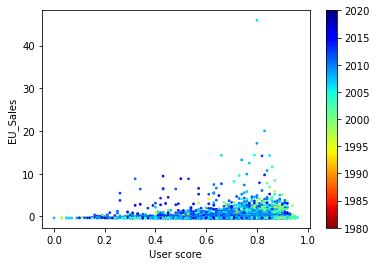

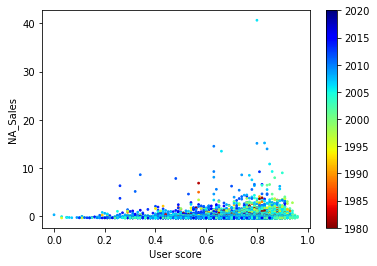

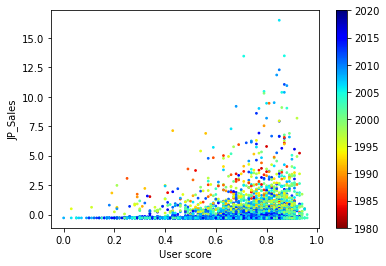

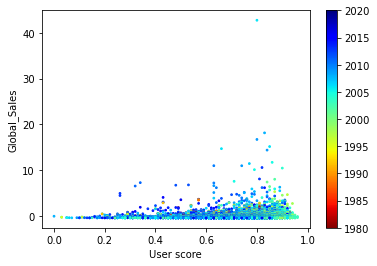

In [250]:
category_column = "Year_of_Release"
ScatterPlotter(data.User_Score, data.EU_Sales, data[category_column])\
    .with_labels('User score', 'EU_Sales')\
    .with_color_bar()\
    .plot()

category_column = "Year_of_Release"
ScatterPlotter(data.User_Score, data.NA_Sales, data[category_column])\
    .with_labels('User score', 'NA_Sales')\
    .with_color_bar()\
    .plot()

category_column = "Year_of_Release"
ScatterPlotter(data.User_Score, data.JP_Sales, data[category_column])\
    .with_labels('User score', 'JP_Sales')\
    .with_color_bar()\
    .plot()

category_column = "Year_of_Release"
ScatterPlotter(data.User_Score, data.Global_Sales, data[category_column])\
    .with_labels('User score', 'Global_Sales')\
    .with_color_bar()\
    .plot()

#TODO

- dodac lata dla brakujących release date z sales większę, bądź równe 0.5m - Arek
- dodac publisherów brakujących - J
- dodac Critic Score recznie dla gier powyzej 8 - J
- dodac User Score recznie dla gier powyzej 8 - J
- zapytac o standaryzacje
- zapytac o uzupelnianie brakujących critic score/user score i czy brac pod uwage jeszcze rok